In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_column',None)
pd.set_option('display.max_row',5000)

In [3]:
records = pd.read_csv("/Users/mk2/Documents - Gabriel’s MacBook Pro/dadaset/records.csv")

### Preprocess

In [4]:
records = records.drop(columns= ["Unnamed: 0"])
records.infer_objects()
records["date"] = pd.to_datetime(records["date"],format='%d/%m/%y')

In [5]:
records = records.sort_values(by=["date","race_index","result"], ascending=False)
records.reset_index(inplace=True, drop=True)


In [70]:
records.columns
records["result"].value_counts()

1.0     1586
2.0     1546
3.0     1460
4.0     1409
5.0     1366
6.0     1319
7.0     1312
8.0     1245
9.0     1205
10.0    1120
11.0    1059
12.0     882
13.0     411
14.0     303
Name: result, dtype: int64

In [7]:
records.drop(columns=['season_stakes', 'total_stakes',
       'win_counts', 'second_count', 'third_count', 'horse_exp',
       'no_starts_past_10', 'current_stable_loc', 'arrival_date',
       'current_rating', 'start_ofseason_rating'],inplace=True)

### Variables

#### Age

In [8]:
records.loc[:,('rest_time')] = (records.groupby('name')["date"].diff(periods=-1).dt.days.fillna(0))

records.loc[:,('cumul_rest_time')] = records.groupby('name')['rest_time'].cumsum().fillna(0)

records.loc[:,('real_age')] = (records['age'] - records['cumul_rest_time']/365).round()

#### General

In [9]:
records.loc[:,('speed')] = (records['dist'] / records['finish_time']).round(2)

records.loc[:,('horse_exp')] = records.groupby(['name']).cumcount(ascending=False)

records.loc[:,("distance_exp")] = records.groupby(["name","dist"]).cumcount(ascending=False)

records.loc[:,("horse_jockey_exp")] = records.groupby(["name","jockey"]).cumcount(ascending=False)

#### Prev

In [10]:
records.loc[:,('prev_speed')] = records.groupby('name')[('speed')].shift(periods=-1)

records.loc[:,('prev_result')] = records.groupby('name')[('result')].shift(periods=-1)

records["prev_actual_weight"] = records.groupby('name')['actual_weight'].shift(periods=-1)

records["prev_declared_weight"] = records.groupby(['name'])['declared_weight'].shift(periods=-1)

records.loc[:,('prev_time')] = records.groupby(["name","dist"])[('finish_time')].shift(periods=-1)

records.loc[:,('prev_running_pos4')] = records.groupby('name')[('running_pos4')].shift(periods=-1)

records.loc[:,('prev_running_pos3')] = records.groupby('name')[('running_pos3')].shift(periods=-1)

records.loc[:,('prev_running_pos2')] = records.groupby('name')[('running_pos2')].shift(periods=-1)

records.loc[:,('prev_running_pos1')] = records.groupby('name')[('running_pos1')].shift(periods=-1)

#### Change

In [11]:
records["actual_wt_change"] = records['actual_weight'] - records['prev_actual_weight']

records["declared_wt_change"] = records['declared_weight'] - records['prev_declared_weight']

records["prev_speed_change"] = records['prev_speed'] - records['prev_speed'].shift(periods=-1)

#### Ranks

In [12]:
records.loc[:,("odds_rank")] = records.loc[:,("win_odds")].rank(pct=True, ascending=False)

records.loc[:,("real_age_rank")] = records.groupby(["race_index","date"])["real_age"].rank(pct=True, ascending=False)

records.loc[:,("cond_odds_rank")] = records.groupby(["race_index","date"])["win_odds"].rank(pct=True, ascending=False)

records.loc[:,("prev_speed_rank")] = records.groupby(["race_index","date"])["prev_speed"].rank(pct=True, ascending=True)

records.loc[:,("distance_exp_rank")] = records.groupby(["race_index","date"])["distance_exp"].rank(pct=True, ascending=True)

records.loc[:,("actual_weight_rank")] = records.groupby(["race_index","date"])["actual_weight"].rank(pct=True, ascending=True)

records.loc[:,("declared_weight_rank")] = records.groupby(["race_index","date"])["declared_weight"].rank(pct=True, ascending=True)

records.loc[:,("actual_wt_change_rank")] = records.groupby(["race_index","date"])["actual_wt_change"].rank(pct=True, ascending=True)

records.loc[:,('prev_running_pos4_rank')] = records.groupby(["race_index","date"])["prev_running_pos4"].rank(pct=True, ascending=True)

records.loc[:,('prev_running_pos3_rank')] = records.groupby(["race_index","date"])["prev_running_pos3"].rank(pct=True, ascending=True)

records.loc[:,('prev_running_pos2_rank')] = records.groupby(["race_index","date"])["prev_running_pos2"].rank(pct=True, ascending=True)

records.loc[:,('prev_running_pos1_rank')] = records.groupby(["race_index","date"])["prev_running_pos1"].rank(pct=True, ascending=True)

In [13]:
records.groupby(["name"])

In [14]:
records.corrwith(records["real_age"])#.plot(kind='barh',vfigsize=(10,20),fontsize=12, grid = True)

race_id                  -0.168685
race_index               -0.168685
result                   -0.001876
dist                      0.274297
race_class               -0.032953
draw                     -0.020960
rating                    0.042691
win_odds                 -0.096879
actual_weight            -0.020577
running_pos1              0.051540
running_pos2              0.051706
running_pos3              0.038247
running_pos4             -0.011866
running_pos5             -0.013447
finish_time               0.274027
declared_weight           0.050152
age                       0.618917
rest_time                -0.050991
cumul_rest_time          -0.268829
real_age                  1.000000
speed                    -0.226136
horse_exp                 0.838517
distance_exp              0.590920
horse_jockey_exp          0.300495
prev_speed               -0.201046
prev_result              -0.006597
prev_actual_weight       -0.027987
prev_declared_weight      0.043134
prev_time           

#### Rolling

In [46]:
roll_records = records.copy()

roll_records = roll_records.set_index(['date'], drop=False)

roll_records.sort_index(ascending=True,inplace=True)

In [47]:
#result_mean

roll_records["168D_average"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("168D", min_periods=1, closed="neither").mean())
roll_records["168D_average_rank"] = roll_records.groupby(["race_index"])["168D_average"].rank(pct=True, ascending=True)

roll_records["112D_average"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("112D", min_periods=1, closed="neither").mean())
roll_records["112D_average_rank"] = roll_records.groupby(["race_index"])["112D_average"].rank(pct=True, ascending=True)

roll_records["84D_average"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("84D", min_periods=1, closed="neither").mean())
roll_records["84D_average_rank"] = roll_records.groupby(["race_index"])["84D_average"].rank(pct=True, ascending=True)

#result_median

roll_records["168D_median"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("168D", min_periods=1, closed="neither").median())
roll_records["168D_median_rank"] = roll_records.groupby(["race_index"])["168D_median"].rank(pct=True, ascending=True)

roll_records["112D_median"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("112D", min_periods=1, closed="neither").median())
roll_records["112D_median_rank"] = roll_records.groupby(["race_index"])["112D_median"].rank(pct=True, ascending=True)

roll_records["84D_median"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("84D", min_periods=1, closed="neither").median())
roll_records["84D_median_rank"] = roll_records.groupby(["race_index"])["84D_median"].rank(pct=True, ascending=True)

#result_max

roll_records["168D_worst"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("168D", min_periods=1, closed="neither").max())
roll_records["168D_worst_rank"] = roll_records.groupby(["race_index"])["168D_worst"].rank(pct=True, ascending=True)

roll_records["112D_worst"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("112D", min_periods=1, closed="neither").max())
roll_records["112D_worst_rank"] = roll_records.groupby(["race_index"])["112D_worst"].rank(pct=True, ascending=True)

roll_records["84D_worst"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("84D", min_periods=1, closed="neither").max())
roll_records["84D_worst_rank"] = roll_records.groupby(["race_index"])["84D_worst"].rank(pct=True, ascending=True)

#result_min

roll_records["168D_best"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("168D", min_periods=1, closed="neither").min())
roll_records["168D_best_rank"] = roll_records.groupby(["race_index"])["168D_best"].rank(pct=True, ascending=True)

roll_records["112D_best"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("112D", min_periods=1, closed="neither").min())
roll_records["112D_best_rank"] = roll_records.groupby(["race_index"])["112D_best"].rank(pct=True, ascending=True)

roll_records["84D_best"] = roll_records.groupby(["name"])["result"].transform(lambda s: s.rolling("84D", min_periods=1, closed="neither").min())
roll_records["84D_best_rank"] = roll_records.groupby(["race_index"])["84D_best"].rank(pct=True, ascending=True)

In [48]:
#speed_mean

roll_records["168D_speed"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("168D", min_periods=1,closed="neither").mean())
roll_records["168D_speed_rank"] = roll_records.groupby(["race_index"])["168D_speed"].rank(pct=True, ascending=True)

roll_records["112D_speed"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("112D", min_periods=1,closed="neither").mean())
roll_records["112D_speed_rank"] = roll_records.groupby(["race_index"])["112D_speed"].rank(pct=True, ascending=True)

roll_records["84D_speed"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("84D", min_periods=1,closed="neither").mean())
roll_records["84D_speed_rank"] = roll_records.groupby(["race_index"])["84D_speed"].rank(pct=True, ascending=True)

#speed_median

roll_records["168D_speed_median"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("168D", min_periods=1,closed="neither").median())
roll_records["168D_speed_median_rank"] = roll_records.groupby(["race_index"])["168D_speed_median"].rank(pct=True, ascending=True)

roll_records["112D_speed_median"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("112D", min_periods=1,closed="neither").median())
roll_records["112D_speed_median_rank"] = roll_records.groupby(["race_index"])["112D_speed_median"].rank(pct=True, ascending=True)

roll_records["84D_speed_median"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("84D", min_periods=1,closed="neither").median())
roll_records["84D_speed_median_rank"] = roll_records.groupby(["race_index"])["84D_speed_median"].rank(pct=True, ascending=True)

#speed_max

roll_records["168D_speed_max"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("168D", min_periods=1,closed="neither").max())
roll_records["168D_speed_max_rank"] = roll_records.groupby(["race_index"])["168D_speed_max"].rank(pct=True, ascending=True)

roll_records["112D_speed_max"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("112D", min_periods=1,closed="neither").max())
roll_records["112D_speed_max_rank"] = roll_records.groupby(["race_index"])["112D_speed_max"].rank(pct=True, ascending=True)

roll_records["84D_speed_max"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("84D", min_periods=1,closed="neither").max())
roll_records["84D_speed_max_rank"] = roll_records.groupby(["race_index"])["84D_speed_max"].rank(pct=True, ascending=True)

#speed_min

roll_records["168D_speed_min"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("168D", min_periods=1,closed="neither").min())
roll_records["168D_speed_min_rank"] = roll_records.groupby(["race_index"])["168D_speed_min"].rank(pct=True, ascending=True)

roll_records["112D_speed_min"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("112D", min_periods=1,closed="neither").min())
roll_records["112D_speed_min_rank"] = roll_records.groupby(["race_index"])["112D_speed_min"].rank(pct=True, ascending=True)

roll_records["84D_speed_min"] = roll_records.groupby(["name"])["speed"].transform(lambda s: s.rolling("84D", min_periods=1,closed="neither").min())
roll_records["84D_speed_min_rank"] = roll_records.groupby(["race_index"])["84D_speed_min"].rank(pct=True, ascending=True)

In [49]:
#prev_finish_time_mean

roll_records["168D_finish_time"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("168D", min_periods=1,closed="neither").mean())
roll_records["168D_finish_time_rank"] = roll_records.groupby(["race_index"])["168D_finish_time"].rank(pct=True, ascending=True)

roll_records["112D_finish_time"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("112D", min_periods=1,closed="neither").mean())
roll_records["112D_finish_time_rank"] = roll_records.groupby(["race_index"])["112D_finish_time"].rank(pct=True, ascending=True)

roll_records["84D_finish_time"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("84D", min_periods=1,closed="neither").mean())
roll_records["84D_finish_time_rank"] = roll_records.groupby(["race_index"])["84D_finish_time"].rank(pct=True, ascending=True)

#prev_finish_time_median

roll_records["168D_finish_time_median"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("168D", min_periods=1,closed="neither").median())
roll_records["168D_finish_time_median_rank"] = roll_records.groupby(["race_index"])["168D_finish_time_median"].rank(pct=True, ascending=True)

roll_records["112D_finish_time_median"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("112D", min_periods=1,closed="neither").median())
roll_records["112D_finish_time_median_rank"] = roll_records.groupby(["race_index"])["112D_finish_time_median"].rank(pct=True, ascending=True)

roll_records["84D_finish_time_median"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("84D", min_periods=1,closed="neither").median())
roll_records["84D_finish_time_median_rank"] = roll_records.groupby(["race_index"])["84D_finish_time_median"].rank(pct=True, ascending=True)

#prev_finish_time_min

roll_records["168D_finish_time_min"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("168D", min_periods=1,closed="neither").min())
roll_records["168D_finish_time_min_rank"] = roll_records.groupby(["race_index"])["168D_finish_time_min"].rank(pct=True, ascending=True)

roll_records["112D_finish_time_min"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("112D", min_periods=1,closed="neither").min())
roll_records["112D_finish_time_min_rank"] = roll_records.groupby(["race_index"])["112D_finish_time_min"].rank(pct=True, ascending=True)

roll_records["84D_finish_time_min"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("84D", min_periods=1,closed="neither").min())
roll_records["84D_finish_time_min_rank"] = roll_records.groupby(["race_index"])["84D_finish_time_min"].rank(pct=True, ascending=True)

#prev_finish_time_max

roll_records["168D_finish_time_max"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("168D", min_periods=1,closed="neither").max())
roll_records["168D_finish_time_max_rank"] = roll_records.groupby(["race_index"])["168D_finish_time_max"].rank(pct=True, ascending=True)

roll_records["112D_finish_time_max"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("112D", min_periods=1,closed="neither").max())
roll_records["112D_finish_time_max_rank"] = roll_records.groupby(["race_index"])["112D_finish_time_max"].rank(pct=True, ascending=True)

roll_records["84D_finish_time_max"] = roll_records.groupby(["name","dist"])["finish_time"].transform(lambda s: s.rolling("84D", min_periods=1,closed="neither").max())
roll_records["84D_finish_time_max_rank"] = roll_records.groupby(["race_index"])["84D_finish_time_max"].rank(pct=True, ascending=True)

In [78]:
roll_records_multindex = roll_records.set_index(['date','race_index'], drop=False)

#prev_jockey_result_mean

roll_records_multindex["168D_jockey"] = roll_records_multindex.groupby(["name"])["prev_result"].transform(lambda s: s.rolling(24, min_periods=1).mean())
roll_records_multindex["168D_jockey_rank"] = roll_records_multindex.groupby(["race_id"])["168D_jockey"].rank(pct=True, ascending=True)

roll_records_multindex["112D_jockey"] = roll_records_multindex.groupby(["name"])["prev_result"].transform(lambda s: s.rolling(16, min_periods=1).mean())
roll_records_multindex["112D_jockey_rank"] = roll_records_multindex.groupby(["race_id"])["112D_jockey"].rank(pct=True, ascending=True)

roll_records_multindex["84D_jockey"] = roll_records_multindex.groupby(["name"])["prev_result"].transform(lambda s: s.rolling(12, min_periods=1).mean())
roll_records_multindex["84D_jockey_rank"] = roll_records_multindex.groupby(["race_id"])["84D_jockey"].rank(pct=True, ascending=True)

In [81]:
roll_records_multindex.reset_index(inplace=True, drop=True)
roll_records_multindex.sort_values(by=["date","race_index","result"], ascending=False)

,race_id,race_index,result,date,venue,dist,turf_quality,race_class,draw,rating,trainer,jockey,lbw,win_odds,actual_weight,running_pos1,running_pos2,running_pos3,running_pos4,running_pos5,finish_time,declared_weight,gear,id,name,details,country_of_origin,age,colour,sex,import_type,trainer.1,owner,sire,dam,dams_sire,same_sire,rest_time,cumul_rest_time,real_age,speed,horse_exp,distance_exp,horse_jockey_exp,prev_speed,prev_result,prev_actual_weight,prev_declared_weight,prev_time,prev_running_pos4,prev_running_pos3,prev_running_pos2,prev_running_pos1,actual_wt_change,declared_wt_change,prev_speed_change,odds_rank,real_age_rank,cond_odds_rank,prev_speed_rank,distance_exp_rank,actual_weight_rank,declared_weight_rank,actual_wt_change_rank,prev_running_pos4_rank,prev_running_pos3_rank,prev_running_pos2_rank,prev_running_pos1_rank,168D_average,168D_average_rank,112D_average,112D_average_rank,84D_average,84D_average_rank,168D_median,168D_median_rank,112D_median,112D_median_rank,84D_median,84D_median_rank,168D_worst,168D_worst_rank,112D_worst,112D_worst_rank,84D_worst,84D_worst_rank,168D_best,168D_best_rank,112D_best,112D_best_rank,84D_best,84D_best_rank,168D_speed,168D_speed_rank,112D_speed,112D_speed_rank,84D_speed,84D_speed_rank,168D_speed_median,168D_speed_median_rank,112D_speed_median,112D_speed_median_rank,84D_speed_median,84D_speed_median_rank,168D_speed_max,168D_speed_max_rank,112D_speed_max,112D_speed_max_rank,84D_speed_max,84D_speed_max_rank,168D_speed_min,168D_speed_min_rank,112D_speed_min,112D_speed_min_rank,84D_speed_min,84D_speed_min_rank,168D_finish_time,168D_finish_time_rank,112D_finish_time,112D_finish_time_rank,84D_finish_time,84D_finish_time_rank,168D_finish_time_median,168D_finish_time_median_rank,112D_finish_time_median,112D_finish_time_median_rank,84D_finish_time_median,84D_finish_time_median_rank,168D_finish_time_min,168D_finish_time_min_rank,112D_finish_time_min,112D_finish_time_min_rank,84D_finish_time_min,84D_finish_time_min_rank,168D_finish_time_max,168D_finish_time_max_rank,112D_finish_time_max,112D_finish_time_max_rank,84D_finish_time_max,84D_finish_time_max_rank,168D_jockey,168D_jockey_rank,112D_jockey,112D_jockey_rank,84D_jockey,84D_jockey_rank
16436,462,462.0,14.0,2022-02-27,"ST / Turf / ""B""",1200.0,G,2.0,8.0,88.0,W Y So,K C Leung,11,117.0,121.0,1.0,1.0,14.0,NaN,NaN,70.94,1231.0,TT,HK_2018_C343,CLASSIC UNICORN,"{'country_of_origin': 'NZ', 'age': 6, 'colour'...",NZ,6,Chestnut,Gelding,PPG,W Y So,Li Fung Lok,Per Incanto,Grace And Eva,Stravinsky,"['A SMILE LIKE YOURS', 'CHARITY GRACE', 'CHIEF...",21.0,21.0,6.0,16.92,15,2,10,17.42,10.0,125.0,1219.0,NaN,NaN,10.0,2.0,3.0,-4.0,12.0,0.50,0.070342,0.285714,0.142857,0.571429,0.285714,0.642857,0.785714,0.357143,NaN,0.892857,0.178571,0.178571,9.0,0.925926,10.000000,0.962963,10.0,0.962963,10.0,0.907407,10.0,0.944444,10.0,0.925926,10.0,0.759259,10.0,0.759259,10.0,0.759259,7.0,0.907407,10.0,0.981481,10.0,0.981481,17.580000,0.925926,17.420000,0.888889,17.420,0.888889,17.420,0.777778,17.420,0.888889,17.420,0.888889,17.94,0.962963,17.42,0.611111,17.42,0.703704,17.38,0.925926,17.42,0.888889,17.42,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.500000,0.666667,5.5000,0.592593,6.272727,0.814815
16335,462,462.0,13.0,2022-02-27,"ST / Turf / ""B""",1200.0,G,2.0,7.0,89.0,P O'Sullivan,C L Chau,7,48.0,119.0,13.0,13.0,13.0,NaN,NaN,70.28,1174.0,V,HK_2018_C135,BAND OF BROTHERS,"{'country_of_origin': 'NZ', 'age': 7, 'colour'...",NZ,7,Chestnut,Gelding,PPG,P O'Sullivan,Z Power Syndicate,Sakhee's Secret,Jan Valachi,Kingdom Bay,['SICOMORO'],24.0,24.0,7.0,17.07,23,2,0,16.92,5.0,113.0,1176.0,68.79,5.0,3.0,4.0,4.0,6.0,-2.0,-0.47,0.187127,0.107143,0.428571,0.285714,0.285714,0.285714,0.500000,0.928571,0.25,0.428571,0.285714,0.321429,5.0,0.425926,5.000000,0.370370,5.0,0.351852,5.0,0.462963,5.0,0.370370,5.0,0.370370,5.0,0.166667,5.0,0.222222,5.0,0.240741,5.0,0.777778,5.0,0.740741,5.0,0.703704,16.920000,0.185185,16.920000,0.185185,16.920,0.1

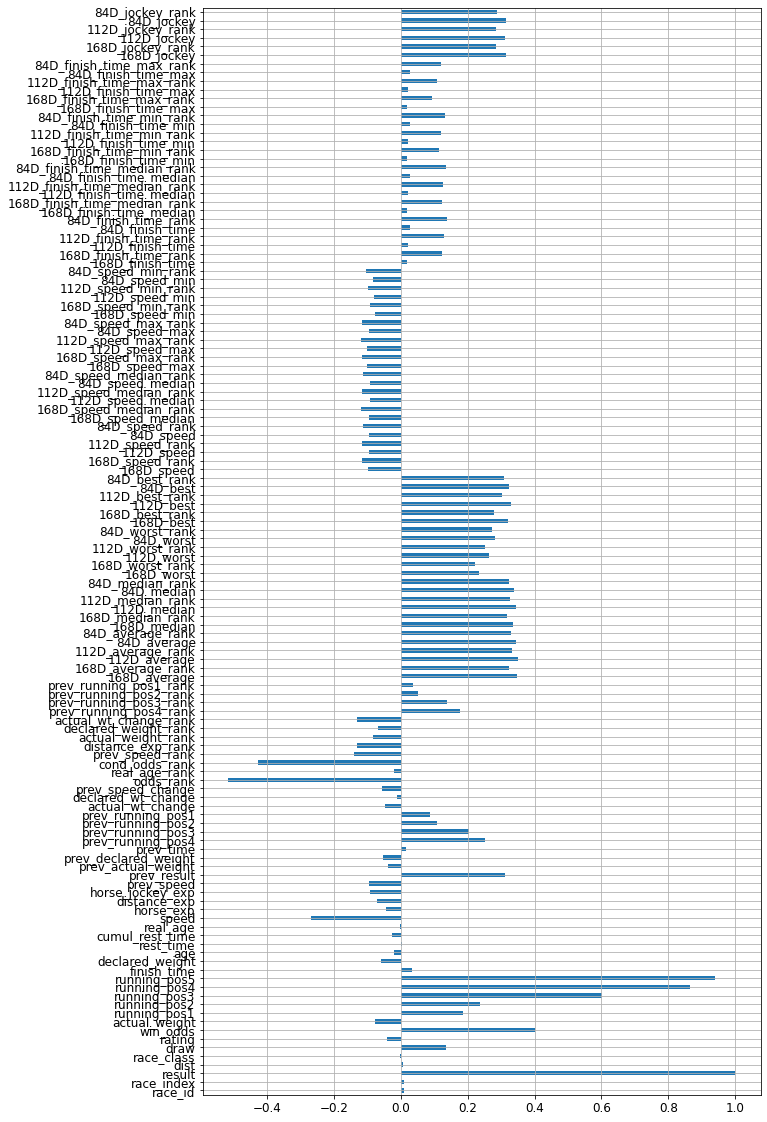

In [83]:
roll_records_multindex.corrwith(roll_records_multindex["result"]).plot(kind='barh',figsize=(10,20),fontsize=12, grid = True)
corr=roll_records_multindex.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

## race_checker

In [74]:
records_notna = records[records.result.notna()]
participants_count = records_notna.groupby(['race_index','date'])['id'].count()
result_sum = records_notna.groupby(['race_index','date'])['result'].sum()

race_checker = (lambda p,r: r == (p / 2)*(1 + p))
race_checked = race_checker(participants_count, result_sum)
race_checked.value_counts()

False    2811
True      322
dtype: int64

0        False
1        False
2        False
3        False
4        False
         ...  
16432    False
16433    False
16434    False
16435    False
16436    False
Name: result, Length: 16437, dtype: bool

In [25]:

def race_checker(p, r):
    
    participants = records.groupby(['race_index','date'])['id'].count()
    result = records.groupby(['race_index','date'])['result'].sum()
    
    for x in p :
        
        if x == 14 and y == 105:
            return True       
        else:
            return False
